In [4]:
#Using Cryptocompare Free API which has historical data for over 90 exchanges, 1800 coins/tokens - 
#CCCAGG is the weighted average price of all exchanges tracked 
#More information - (https://www.cryptocompare.com/coins/guides/how-does-our-cryptocurrecy-index-work/)
#2000 limit of rows

from_symbol = 'BTC'
to_symbol = 'USD'

exchange = 'CCCAGG'
#Intervals supported minute, hour and day
datetime_interval = 'day'

In [5]:
import pandas as pd
import requests
from datetime import datetime

In [6]:
#Functions to automate naming and saving of csv files from API

def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    #Use aggregate to group different periods of time
    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df


data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)


Filtering 0 empty datapoints
Saving data to BTC_USD_CCCAGG_day_2018-03-27.csv


In [7]:
def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)


Reading data from BTC_USD_CCCAGG_day_2018-03-27.csv
(2001, 6)


In [8]:
df.head()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2012-10-05,12.51,12.97,12.85,12.69,31258.44,398427.10
2012-10-06,12.35,12.86,12.69,12.51,24673.41,310513.02
2012-10-07,11.70,12.62,12.51,11.80,63512.03,762812.96
2012-10-08,10.62,11.95,11.80,11.78,97938.40,1102329.22
2012-10-09,11.57,12.35,11.78,11.90,46768.80,559694.91


In [9]:
df.tail()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2018-03-24,8515.53,9036.23,8935.51,8548.06,93296.24,8.276632e+08
2018-03-25,8395.85,8690.36,8548.39,8472.84,76775.64,6.576435e+08
2018-03-26,7869.27,8521.04,8472.56,8152.20,131859.97,1.079039e+09
2018-03-27,7752.30,8226.24,8152.18,7808.48,116523.10,9.307550e+08
2018-03-28,7752.60,7871.41,7808.42,7871.41,11370.88,8.896008e+07


In [10]:
df.describe()

,low,high,open,close,volumefrom,volumeto
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03
mean,1399.678236,1529.051944,1469.353908,1473.283673,60997.379055,1.665281e+08
std,2798.278392,3118.456378,2979.201830,2982.449703,59825.056071,4.786109e+08
min,9.740000,10.650000,10.170000,10.170000,404.380000,1.094799e+05
25%,231.460000,239.420000,235.400000,235.600000,21374.200000,3.777108e+06
50%,429.830000,451.210000,441.920000,442.000000,44475.890000,1.528111e+07
75%,839.440000,910.470000,888.870000,891.070000,82590.480000,4.665765e+07
max,18750.910000,19870.620000,19346.600000,19345.490000,572349.320000,6.245732e+09


In [11]:
import talib as ta
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')

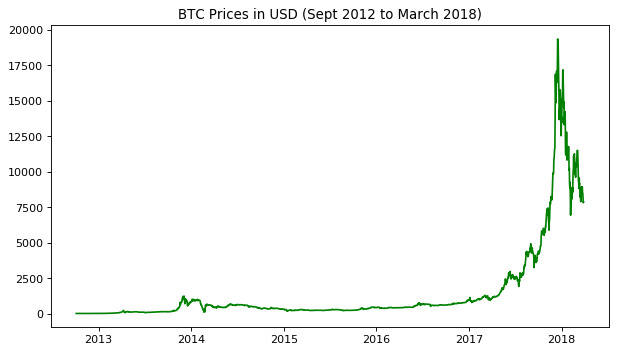

In [12]:
plt.plot(df.close, color='g')
plt.title('BTC Prices in USD (Sept 2012 to March 2018)')
plt.show()

In [13]:
#Shift price 7 days behind 
df['targetprice'] = df['close'].shift(-7)

#Using technical analysis library to create common technical indicators

#Common Technical Analysis Indicators
df['SMA'] = ta.SMA(df.close)
df['AD'] = ta.AD(df.high,df.low,df.close,df.volumefrom)
df['ADOSC'] = ta.ADOSC(df.high,df.low,df.close,df.volumefrom)
df['ADX'] = ta.ADX(df.high,df.low,df.close)
df['ADXR'] = ta.ADXR(df.high,df.low,df.close)
df['APO'] = ta.APO(df.close)
df['AROONOSC'] = ta.AROONOSC(df.high,df.low)
df['ATR'] = ta.ATR(df.high,df.low,df.close)
df['BOP'] = ta.BOP(df.open,df.high,df.low,df.close)
df['CCI'] = ta.CCI(df.high,df.low,df.close)
df['CMO'] = ta.CMO(df.close)
df['DEMA'] = ta.DEMA(df.close)
df['DX'] = ta.DX(df.high,df.low,df.close)
df['EMA'] = ta.EMA(df.close)
df['HT_TRENDMODE'] = ta.HT_TRENDMODE(df.close)
df['HT_TRENDLINE'] = ta.HT_TRENDLINE(df.close)
df['KAMA'] = ta.KAMA(df.close)
df['MA'] = ta.MA(df.close)
df['MFI'] = ta.MFI(df.high,df.low,df.close,df.volumefrom)
df['MINUS_DI'] = ta.MINUS_DI(df.high,df.low,df.close)
df['MINUS_DM'] = ta.MINUS_DM(df.high,df.low)
df['MOM'] = ta.MOM(df.close)
df['OBV'] = ta.OBV(df.close,df.volumefrom)
df['PLUS_DI'] = ta.PLUS_DI(df.high,df.low,df.close)
df['PLUS_DM'] = ta.PLUS_DM(df.high,df.low)
df['PPO'] = ta.PPO(df.close)
df['ROCP'] = ta.ROCP(df.close)
df['RSI'] = ta.RSI(df.close)
df['SAR'] = ta.SAR(df.high,df.low)
df['SAREXT'] = ta.SAREXT(df.high,df.low)
df['SMA'] = ta.SMA(df.close)
df['T3'] = ta.T3(df.close)
df['TEMA'] = ta.TEMA(df.close)
df['TRANGE'] = ta.TRANGE(df.high,df.low,df.close)
df['TRIX'] = ta.TRIX(df.close)
df['ULTOSC'] = ta.ULTOSC(df.high,df.low,df.close)
df['WILLR'] = ta.WILLR(df.high,df.low,df.close)
df['WMA'] = ta.WMA(df.close)

#Candlestick indicators
df['CDL2CROWS'] = ta.CDL2CROWS(df.open,df.high,df.low,df.close)
df['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(df.open,df.high,df.low,df.close)
df['CDL3INSIDE'] = ta.CDL3INSIDE(df.open,df.high,df.low,df.close)
df['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(df.open,df.high,df.low,df.close)
df['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(df.open,df.high,df.low,df.close)
df['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(df.open,df.high,df.low,df.close)
df['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(df.open,df.high,df.low,df.close)
df['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(df.open,df.high,df.low,df.close)
df['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(df.open,df.high,df.low,df.close)
df['CDLBELTHOLD'] = ta.CDLBELTHOLD(df.open,df.high,df.low,df.close)
df['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(df.open,df.high,df.low,df.close)
df['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(df.open,df.high,df.low,df.close)
df['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(df.open,df.high,df.low,df.close)
df['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(df.open,df.high,df.low,df.close)
df['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(df.open,df.high,df.low,df.close)
df['CDLDOJI'] = ta.CDLDOJI(df.open,df.high,df.low,df.close)
df['CDLDOJISTAR'] = ta.CDLDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(df.open,df.high,df.low,df.close)
df['CDLENGULFING'] = ta.CDLENGULFING(df.open,df.high,df.low,df.close)
df['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(df.open,df.high,df.low,df.close)
df['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(df.open,df.high,df.low,df.close)
df['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(df.open,df.high,df.low,df.close)
df['CDLHAMMER'] = ta.CDLHAMMER(df.open,df.high,df.low,df.close)
df['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(df.open,df.high,df.low,df.close)
df['CDLHARAMI'] = ta.CDLHARAMI(df.open,df.high,df.low,df.close)
df['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(df.open,df.high,df.low,df.close)
df['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(df.open,df.high,df.low,df.close)
df['CDLHIKKAKE'] = ta.CDLHIKKAKE(df.open,df.high,df.low,df.close)
df['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(df.open,df.high,df.low,df.close)
df['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(df.open,df.high,df.low,df.close)
df['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(df.open,df.high,df.low,df.close)
df['CDLINNECK'] = ta.CDLINNECK(df.open,df.high,df.low,df.close)
df['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(df.open,df.high,df.low,df.close)
df['CDLKICKING'] = ta.CDLKICKING(df.open,df.high,df.low,df.close)
df['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(df.open,df.high,df.low,df.close)
df['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(df.open,df.high,df.low,df.close)
df['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(df.open,df.high,df.low,df.close)
df['CDLLONGLINE'] = ta.CDLLONGLINE(df.open,df.high,df.low,df.close)
df['CDLMARUBOZU'] = ta.CDLMARUBOZU(df.open,df.high,df.low,df.close)
df['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(df.open,df.high,df.low,df.close)
df['CDLMATHOLD'] = ta.CDLMATHOLD(df.open,df.high,df.low,df.close)
df['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(df.open,df.high,df.low,df.close)
df['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(df.open,df.high,df.low,df.close)
df['CDLONNECK'] = ta.CDLONNECK(df.open,df.high,df.low,df.close)
df['CDLPIERCING'] = ta.CDLPIERCING(df.open,df.high,df.low,df.close)
df['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(df.open,df.high,df.low,df.close)
df['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(df.open,df.high,df.low,df.close)
df['CDLSEPARATINGLINES'] = ta.CDLSEPARATINGLINES(df.open,df.high,df.low,df.close)
df['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(df.open,df.high,df.low,df.close)
df['CDLSHORTLINE'] = ta.CDLSHORTLINE(df.open,df.high,df.low,df.close)
df['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(df.open,df.high,df.low,df.close)
df['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(df.open,df.high,df.low,df.close)
df['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(df.open,df.high,df.low,df.close)
df['CDLTAKURI'] = ta.CDLTAKURI(df.open,df.high,df.low,df.close)
df['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(df.open,df.high,df.low,df.close)
df['CDLTHRUSTING'] = ta.CDLTHRUSTING(df.open,df.high,df.low,df.close)
df['CDLTRISTAR'] = ta.CDLTRISTAR(df.open,df.high,df.low,df.close)
df['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(df.open,df.high,df.low,df.close)
df['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(df.open,df.high,df.low,df.close)
df['CDLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(df.open,df.high,df.low,df.close)


In [14]:
df.tail(30)

,low,high,open,close,volumefrom,volumeto,targetprice,SMA,AD,ADOSC,...,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-27,10154.24,10879.38,10326.50,10594.76,99772.39,1.060841e+09,10735.45,9490.828667,1.613376e+07,-1233.044626,...,0,0,0,0,0,0,0,0,0,0
2018-02-28,10303.14,11067.76,10594.76,10334.44,105434.79,1.126075e+09,9928.56,9460.845000,1.603696e+07,-22920.150516,...,0,0,0,0,0,0,0,0,0,0
2018-03-01,10247.56,11090.30,10334.44,10929.37,88432.44,9.524721e+08,9316.72,9488.248667,1.609162e+07,-12317.238577,...,0,0,0,0,0,0,0,0,0,0
2018-03-02,10801.45,11191.94,10929.37,11043.12,77195.49,8.529085e+08,9252.76,9515.457333,1.610997e+07,-1019.579289,...,100,0,0,0,0,0,0,0,0,0
2018-03-03,11043.12,11530.66,11043.12,11465.36,71279.36,8.122001e+08,8797.27,9593.812000,1.616216e+07,20299.315009,...,0,0,0,0,0,0,0,0,0,0
2018-03-04,11084.01,11539.79,11465.36,11504.42,61016.39,6.907273e+08,9544.84,9681.598667,1.621370e+07,43576.368814,...,0,0,0,100,0,0,0,0,0,0
2018-03-05,11431.55,11694.15,11503.94,11440.73,68323.51,7.914719e+08,9142.15,9754.580667,1.615016e+07,28917.942844,...,0,0,0,0,0,0,0,0,0,0
2018-03-06,10589.28,11441.65,11440.33,10735.45,109876.55,1.210081e+09,9160.12,9838.494000,1.607797e+07,-2677.722870,...,0,0,0,0,0,0,0,0,0,0
2018-03-07,9470.73,10913.70,10735.45,9928.56,183060.08,1.858869e+09,8217.70,9938.210000,1.601107e+07,-36644.992011,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df = df.loc[:, (df != 0).any(axis=0)]
df.describe()

,low,high,open,close,volumefrom,volumeto,targetprice,SMA,AD,ADOSC,...,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLTAKURI
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03,1994.000000,1972.000000,2.001000e+03,1992.000000,...,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,1399.678236,1529.051944,1469.353908,1473.283673,60997.379055,1.665281e+08,1478.413139,1430.747740,6.025112e+06,28466.666231,...,18.190905,5.797101,1.149425,2.148926,15.142429,0.499750,2.198901,-0.399800,-0.299850,1.799100
std,2798.278392,3118.456378,2979.201830,2982.449703,59825.056071,4.786109e+08,2986.423114,2889.752483,3.943963e+06,48057.041644,...,38.586598,40.452155,16.842748,14.504476,35.855156,9.987498,48.530016,52.438918,5.469008,13.295173
min,9.740000,10.650000,10.170000,10.170000,404.380000,1.094799e+05,10.170000,11.030667,-6.569243e+04,-148951.794029,...,0.000000,-100.000000,-100.000000,0.000000,0.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.000000
25%,231.460000,239.420000,235.400000,235.600000,21374.200000,3.777108e+06,235.870000,236.815917,3.768723e+06,-2116.990724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,429.830000,451.210000,441.920000,442.000000,44475.890000,1.528111e+07,442.645000,451.368833,4.009961e+06,16474.122860,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,839.440000,910.470000,888.870000,891.070000,82590.480000,4.665765e+07,892.450000,852.008167,7.922399e+06,54816.962075,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18750.910000,19870.620000,19346.600000,19345.490000,572349.320000,6.245732e+09,19345.490000,15737.841333,1.636442e+07,291297.349657,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,100.000000


In [16]:
#Delete rows with NAN
df2 = df.dropna()
df2

#Delete columns with all 0s
df2 = df2.loc[:, (df != 0).any(axis=0)]
df2


,low,high,open,close,volumefrom,volumeto,targetprice,SMA,AD,ADOSC,...,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLTAKURI
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13.16,13.56,13.51,13.30,28406.21,3.788793e+05,13.74,13.413667,5.219438e+05,5467.546045,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,13.16,13.40,13.30,13.28,17966.81,2.391562e+05,13.77,13.433667,5.219438e+05,3416.469685,...,100,0,0,0,100,0,0,-100,0,0
2013-01-03,13.25,13.46,13.28,13.40,18032.25,2.408459e+05,14.14,13.433333,5.296719e+05,4725.748021,...,0,100,0,0,0,0,0,0,0,0
2013-01-04,13.27,13.52,13.40,13.50,29641.92,3.978843e+05,14.14,13.437333,5.545711e+05,12754.225229,...,0,0,0,0,0,0,0,0,0,0
2013-01-05,13.31,13.55,13.50,13.44,21329.93,2.869325e+05,14.24,13.442000,5.563486e+05,15444.693574,...,0,0,0,0,0,0,0,0,0,0
2013-01-06,13.36,13.52,13.44,13.45,12741.13,1.714970e+05,14.12,13.440333,5.579413e+05,15648.026152,...,100,0,0,0,100,0,100,100,0,0
2013-01-07,13.40,13.59,13.45,13.59,25477.72,3.440833e+05,14.30,13.446000,5.834190e+05,22415.207101,...,0,100,0,0,0,0,0,0,0,0
2013-01-08,13.50,13.88,13.59,13.74,42798.37,5.872239e+05,14.25,13.457667,5.946817e+05,26729.448782,...,0,0,0,0,0,0,0,0,0,0
2013-01-09,13.62,13.86,13.74,13.77,28606.38,3.931922e+05,14.73,13.469000,6.018333e+05,28339.923444,...,0,0,0,0,0,0,0,100,0,0


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split
import numpy as np


X = df.drop(df[['low','high','open','close','volumefrom','volumeto','targetprice']], axis = 1)
#Drop out NAN
X = X.dropna()
#Drop last row
X = X[:-7]

In [18]:
# This creates a LinearRegression object
lm = LinearRegression()
lm.fit(X,df2.targetprice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]


,features,estimatedCoefficients
0,SMA,-0.604434
1,AD,0.000169
2,ADOSC,0.000569
3,ADX,3.518927
4,ADXR,-1.192270
5,APO,1.027555
6,AROONOSC,0.141057
7,ATR,4.208532
8,BOP,-41.332001
9,CCI,-0.099565


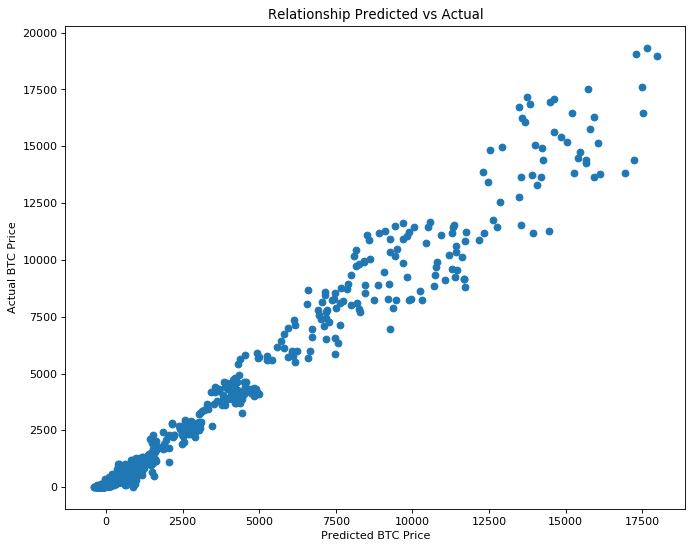

In [20]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(lm.predict(X), df2.targetprice)
plt.xlabel("Predicted BTC Price")
plt.ylabel("Actual BTC Price")
plt.title("Relationship Predicted vs Actual")
plt.show()

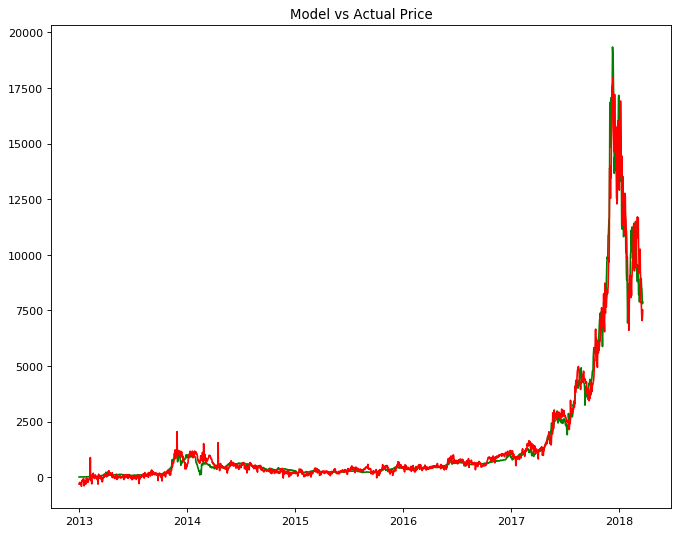

R-Squared score: 0.978


In [21]:
#Line Graph
df3 = df2
df3['predictedmodel LM'] = lm.predict(X)
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(df3.targetprice, color='g')
plt.plot(df3['predictedmodel LM'], color='r')
plt.title("Model vs Actual Price")
plt.show()
print('R-Squared score: {:.3f}'.format(lm.score(X,df2.targetprice)))


In [22]:
#Hypertuning Ridge Regression

#Time Series cross-validator
#Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets.
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.linear_model import Ridge
tscv = TimeSeriesSplit(n_splits=5)

# prepare a range of alpha values to test
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=tscv)
grid.fit(X, df2.targetprice)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)



GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
-8.24418621685
1.0


In [23]:
#Ridge regression - best estimator alpha = 1

from sklearn.linear_model import Ridge
#Alpha is the parameter penalty - regulariztion - higher # higher penalty which will reduce complexity
linridge = Ridge(alpha=1).fit(X,df2.targetprice)
#Feature normalization so alpha penalty is applied equaly for all feature variables

print('ridge regression linear model intercept: {}'.format(linridge.intercept_))
print('ridge regression linear model coeff: {}'.format(linridge.coef_))
print('R-squared score: {:.3f}'.format(linridge.score(X,df2.targetprice)))
print('Number of non-zero features {:.3f}'.format(np.sum(linridge.coef_ != 0)))


df3['Ridge'] = linridge.predict(X)


ridge regression linear model intercept: -420.54958734695265
ridge regression linear model coeff: [ -6.04375575e-01   1.68906565e-04   5.68486489e-04   3.52185166e+00
  -1.19293175e+00   1.02689758e+00   1.41796040e-01   4.20802874e+00
  -4.10770656e+01  -9.97309983e-02   6.61883868e+00   6.30481043e-01
   1.76588354e-01  -4.04698777e+00   5.56618854e+01   1.03042779e-01
  -2.21856878e+00  -6.04371230e-01   7.09765433e-02   6.05332369e+00
  -1.65144818e+00   1.39045183e-02  -1.43782278e-04  -1.68455764e+01
   1.13767796e+00   2.93331285e+00   6.75988571e+01   3.30941936e+00
   6.97185493e-01   1.08813258e-01   1.51759797e+00  -5.57103472e+00
   9.25625048e-01   5.26311061e+01  -4.48200936e+00  -5.39764032e-01
   1.08561838e+01  -1.29008522e+01   1.34505236e+01  -3.69762510e-01
   1.51443507e+00   4.62464131e-01   4.88267717e-01   5.08792985e-01
  -1.86478434e+00   3.26360399e-01   1.76557826e+01  -1.36480575e+00
   5.90776763e-01   1.73175304e+00  -5.41787495e+00  -3.11210295e-02
   1.

In [24]:
#Ridge Regression - normalizing features so alpha regularization applied uniformly
#MinMaxScaler is one of the most popular transform methods
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
linridge2 = Ridge(alpha=1).fit(X_scaled,df2.targetprice)
r2_score = linridge2.score(X_scaled,df2.targetprice)
print(r2_score)

df3['RidgeNormalized'] = linridge2.predict(X_scaled)


0.968241324005


In [25]:
#Kernel Ridge Regression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge

scaler = MinMaxScaler()

X_scaledK = scaler.fit_transform(X)
RidgeK = KernelRidge(alpha=1).fit(X_scaledK,df2.targetprice)
#kr_r2_score = KernelRidge.score(X_scaledK,df2.targetprice)
#print(kr_r2_score)

df3['KernelRidgeNormalized'] = RidgeK.predict(X_scaledK)



In [27]:
#K Nearest Neighbor Hypertuned
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaledK = scaler.fit_transform(X)


tscv = TimeSeriesSplit(n_splits=5)

tuned_parameters = {"n_neighbors": [1,2,3,4,5,6,7,8,9,10], 
                    "weights": ["distance", "uniform"], 
                    "algorithm": ["ball_tree", "kd_tree", "brute"]}

KNei = KNeighborsRegressor()

clf = GridSearchCV(KNei, tuned_parameters, cv=tscv)

clf.fit(X_scaledK, df2.targetprice)

print("Tuned K Nearest Neighbor Parameters: {}".format(clf.best_params_))



Tuned K Nearest Neighbor Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}


In [28]:
#K Nearest Neighbor Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaledK = scaler.fit_transform(X)

knnreg = KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='ball_tree').fit(X_scaledK,df2.targetprice)

print('R-squared test score: {}'.format(knnreg.score(X_scaledK,df2.targetprice)))

df3['KNeighbors'] = knnreg.predict(X_scaledK)


R-squared test score: 0.9628843645753993


In [44]:
# Hypertuning Tree regression
from scipy.stats import randint
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "criterion": ["mse", "friedman_mse","mae"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=tscv)

# Fit it to the data
tree_cv.fit(X,df2.targetprice)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 4}
Best score is -0.5949634611895335


In [39]:
#Tree Based Regressor with hypertuning
from sklearn.tree import DecisionTreeRegressor

# Instantiate a Decision Tree regressor: tree
tree = DecisionTreeRegressor()

tree = DecisionTreeRegressor( max_features=7, min_samples_leaf=4, criterion='friedman_mse').fit(X,df2.targetprice)

print('R-squared test score: {}'.format(tree.score(X,df2.targetprice)))

df3['Tree'] = tree.predict(X)


R-squared test score: 0.9970538927593867


In [36]:
#Ensemble Gradient Boosting
#Hypertuning 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

# Setup the parameters and distributions to sample from: param_dist

param_dist = {"max_depth": [3,4,5, None],
              "max_features": [1,2,3,4,5,6,7,8,9],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
              "subsample":[0.6,0.7,0.75,0.8,0.85,0.9],
             "learning_rate":[0.05,.1,.2],
             'n_estimators':range(20,91,10)}

# Instantiate a Decision Tree classifier: tree
GradientBoost = GradientBoostingRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
grad_boost = GridSearchCV(GradientBoost, param_dist, cv=tscv)

# Fit it to the data
grad_boost.fit(X,df2.targetprice)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grad_boost.best_params_))
print("Best score is {}".format(grad_boost.best_score_))



Tuned Decision Tree Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 4, 'n_estimators': 30, 'subsample': 0.75}
Best score is -0.32021099582940454


In [37]:
gradient = GradientBoostingRegressor()

gradient = GradientBoostingRegressor(max_features=2, min_samples_leaf=4, learning_rate= .2, max_depth = 5, n_estimators=30, subsample = 0.75).fit(X,df2.targetprice)

print('R-squared test score: {}'.format(gradient.score(X,df2.targetprice)))

df3['Gradient'] = gradient.predict(X)

R-squared test score: 0.9959932444280822


In [155]:
#XGBoost which has parallel processing over Gradient boost sklearn
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
price_matrix = xgb.DMatrix(data=X,label = df2.targetprice)

gbm_param_grid = {
    'learning_rate': [0.01,0.1,0.5,0.9],
    'n_estimators': [200],
    'subsample' : [0.3,0.5,0.9],
    'max_depth': np.arange(3,20,1),
    'colsample_bytree' : np.arange(.1,1.05,.05)
}

gbm = xgb.XGBRegressor()

#switching to randomized search
grid_mse = RandomizedSearchCV(estimator = gbm, param_distributions=gbm_param_grid, n_iter=25, scoring= 'neg_mean_squared_error',cv = tscv, verbose=1)
grid_mse.fit(X,df2.targetprice)

print("Best parameters found: ", grid_mse.best_params_)
print("Best RMSE found:", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.5min finished


Best parameters found:  {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 14, 'learning_rate': 0.5, 'colsample_bytree': 0.55000000000000016}
Best RMSE found: 3049.08771108


In [114]:
import xgboost as xgb

xgbboost = xgb.XGBRegressor()
xgbboost = xgb.XGBRegressor(subsample=0.3, n_estimators=200, max_depth= 19, learning_rate = 0.9, colsample_bytree=0.6).fit(X,df2.targetprice)

print('R-squared test score: {}'.format(xgbboost.score(X,df2.targetprice)))
df3['XGB'] = xgbboost.predict(X)

R-squared test score: 0.9960324725381979


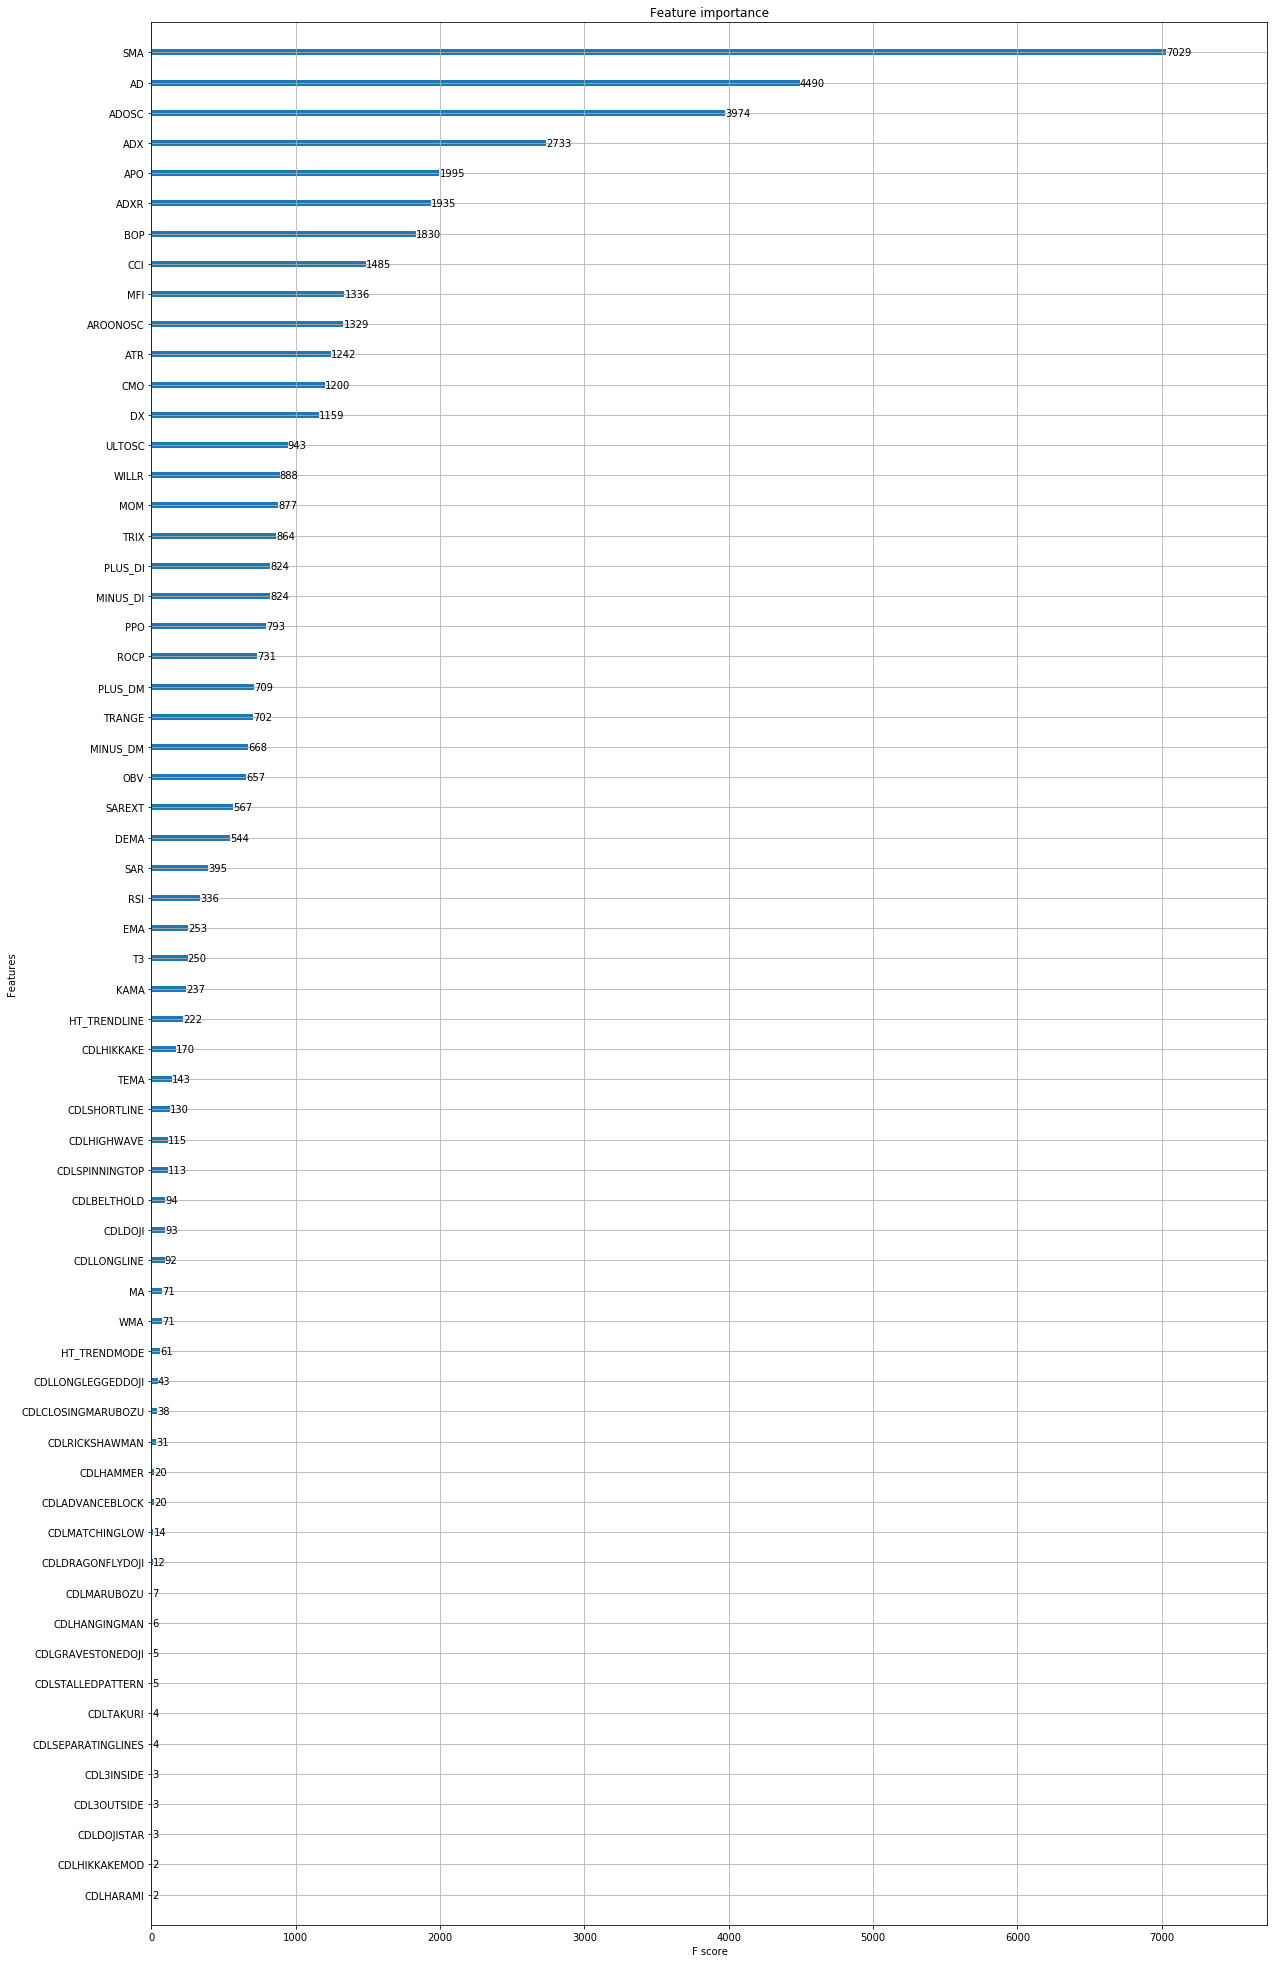

In [123]:
#Visualizing feature importances
xgb.plot_importance(xgbboost)

fig = plt.gcf()
fig.set_size_inches(20, 35)

plt.show()


In [82]:
lineplot = df3[['targetprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree', 'Gradient','XGB']]
lineplot

,targetprice,predictedmodel LM,Ridge,RidgeNormalized,KernelRidgeNormalized,KNeighbors,Tree,Gradient,XGB
datetime,,,,,,,,,
2013-01-01,13.74,-305.011078,-304.924599,-307.741905,-292.865081,311.814,13.982000,83.243718,221.046616
2013-01-02,13.77,-253.147717,-252.953772,-232.550431,-202.444247,346.033,13.982000,123.279516,260.643280
2013-01-03,14.14,-270.684679,-270.426948,-232.843757,-206.648287,231.267,13.982000,89.920450,203.389786
2013-01-04,14.14,-225.053161,-224.770640,-116.610623,-90.232295,226.697,13.982000,82.788995,2.243103
2013-01-05,14.24,-306.817708,-306.615921,-298.126002,-281.156699,269.473,14.380000,82.788995,-15.108414
2013-01-06,14.12,-248.594467,-248.446181,-270.110274,-282.823412,312.115,13.982000,101.028053,-298.610535
2013-01-07,14.30,-257.769005,-257.527368,-249.792694,-232.029738,175.712,14.380000,67.643013,16.503380
2013-01-08,14.25,-342.254556,-341.860868,-319.189635,-332.868251,276.409,14.380000,94.281551,131.148956
2013-01-09,14.73,-402.618550,-402.603764,-353.863657,-326.043704,479.235,14.380000,84.047725,-171.984787


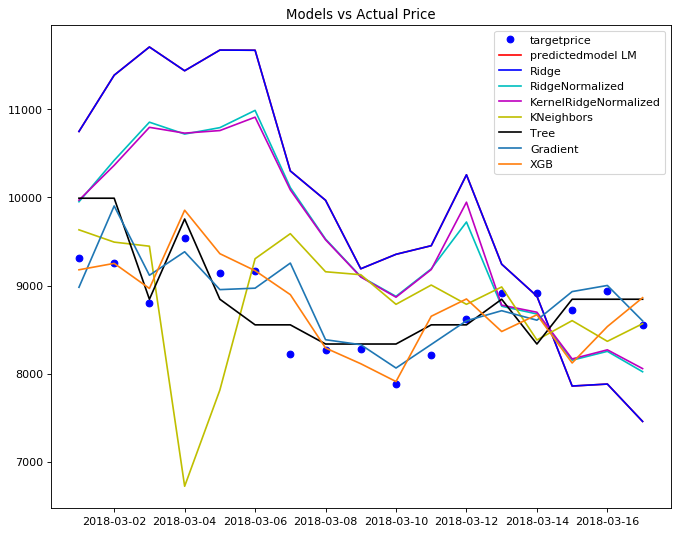

In [83]:
import matplotlib.pyplot as plt
import datetime
import math
from sklearn.metrics import mean_squared_error


fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
lineplot = df3[['targetprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree','Gradient','XGB']]
lineplot = lineplot.loc['2018-3-1':'2018-3-17']

plt.plot(lineplot.targetprice, 'bo')
plt.plot(lineplot['predictedmodel LM'], color='r')
plt.plot(lineplot.Ridge, color='b')
plt.plot(lineplot.RidgeNormalized, color='c')
plt.plot(lineplot.KernelRidgeNormalized, color='m')
plt.plot(lineplot.KNeighbors, color='y')
plt.plot(lineplot.Tree, color='k')
plt.plot(lineplot.Gradient)
plt.plot(lineplot.XGB)


plt.legend(loc='upper right')
plt.title("Models vs Actual Price")
plt.show()



In [84]:
#RMSE for this time period
import math
from sklearn.metrics import mean_squared_error

LM = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['predictedmodel LM']))
Ridge = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Ridge']))
RidgeN = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['RidgeNormalized']))
RidgeKerN = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['KernelRidgeNormalized']))
RidgeKNei = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['KNeighbors']))
Tree = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Tree']))
Gradient = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Gradient']))
XGB = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['XGB']))


print(LM)
print(Ridge)
print(RidgeN)
print(RidgeKerN)
print(RidgeKNei)
print(Tree)
print(Gradient)
print(XGB)


1696.0597803506082
1696.0531692559723
1177.2582074092652
1167.1457358976652
963.7195440329709
375.2181827850793
348.0429108118542
325.54084548292724


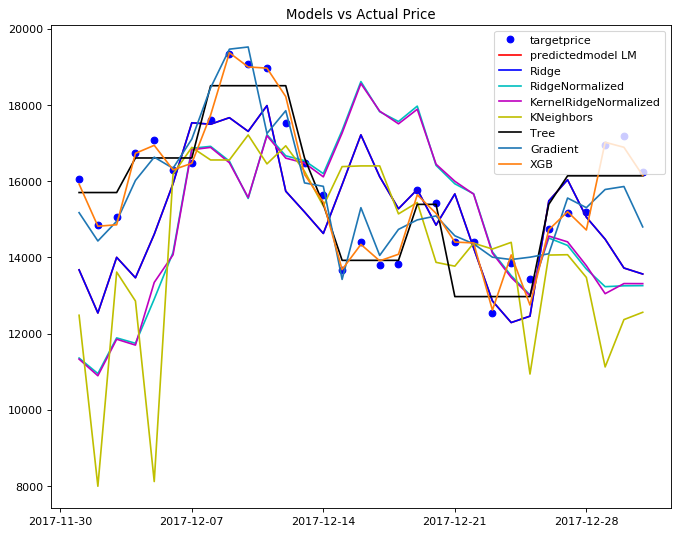

In [86]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

lineplot = df3[['targetprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree','Gradient','XGB']]
lineplot = lineplot.loc['2017-12-1':'2017-12-31']

plt.plot(lineplot.targetprice, 'bo')
plt.plot(lineplot['predictedmodel LM'], color='r')
plt.plot(lineplot.Ridge, color='b')
plt.plot(lineplot.RidgeNormalized, color='c')
plt.plot(lineplot.KernelRidgeNormalized, color='m')
plt.plot(lineplot.KNeighbors, color='y')
plt.plot(lineplot.Tree, color='k')
plt.plot(lineplot.Gradient)
plt.plot(lineplot.XGB)

plt.legend(loc='upper right')
plt.title("Models vs Actual Price")
plt.show()


In [87]:
#RMSE for this time period
import math
from sklearn.metrics import mean_squared_error

LM = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['predictedmodel LM']))
Ridge = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Ridge']))
RidgeN = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['RidgeNormalized']))
RidgeKerN = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['KernelRidgeNormalized']))
RidgeKNei = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['KNeighbors']))
Tree = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Tree']))
Gradient = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['Gradient']))
XGB = math.sqrt(mean_squared_error(lineplot['targetprice'], lineplot['XGB']))


print(LM)
print(Ridge)
print(RidgeN)
print(RidgeKerN)
print(RidgeKNei)
print(Tree)
print(Gradient)
print(XGB)

1753.236020117263
1753.2763693757431
2749.9285410925445
2733.4311835207304
3025.662120108306
682.9041269221356
743.4036432907905
234.80533768445483


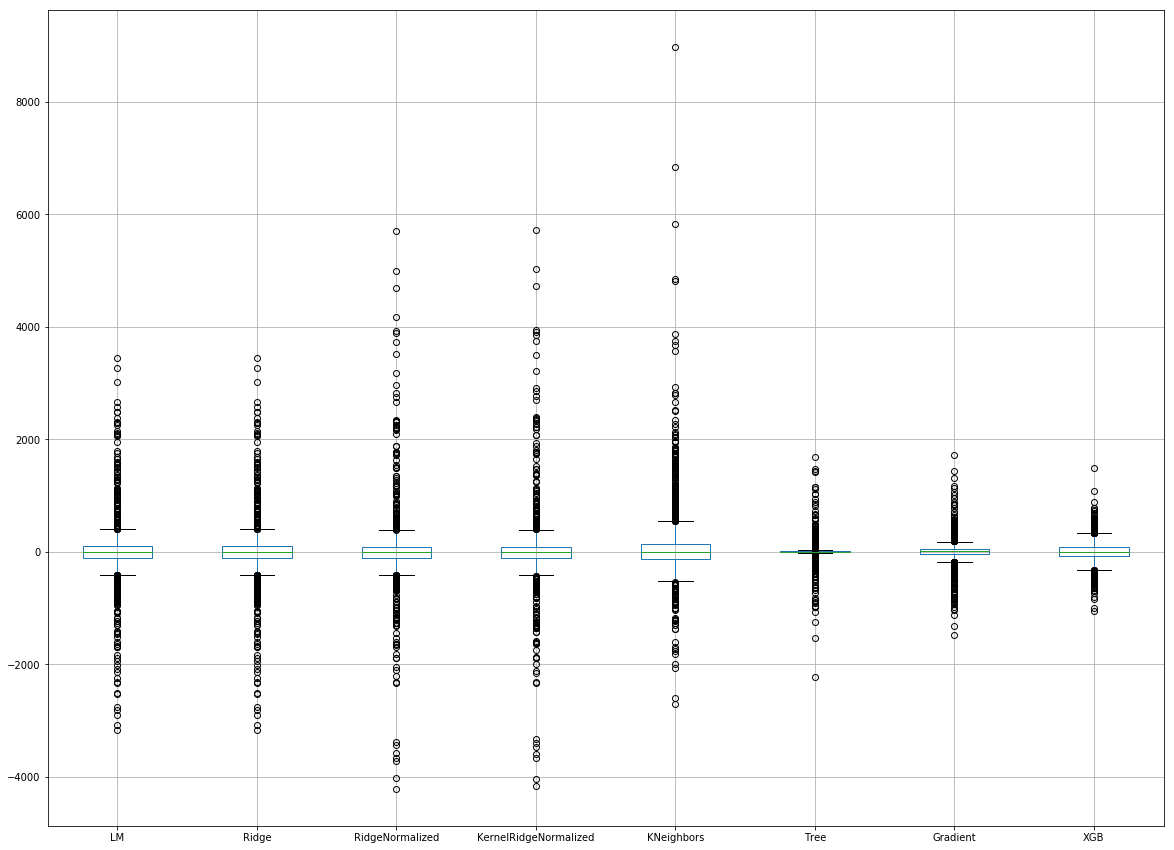

In [98]:
#Create residual Boxplots
LM_Residual = df3['targetprice'] - df3['predictedmodel LM']
Ridge_Residual = df3['targetprice'] - df3['Ridge']
RidgeN = df3['targetprice'] - df3['RidgeNormalized']
RidgeKerN = df3['targetprice'] - df3['KernelRidgeNormalized']
RidgeKNei = df3['targetprice'] - df3['KNeighbors']
Tree = df3['targetprice'] - df3['Tree']
Gradient = df3['targetprice'] - df3['Gradient']
XGB = df3['targetprice'] - df3['XGB']

boxplotsdf = pd.concat([LM_Residual,Ridge_Residual,RidgeN,RidgeKerN,RidgeKNei,Tree,Gradient,XGB], axis=1)
boxplotsdf.rename(columns={0:'LM',1:'Ridge',2:'RidgeNormalized',3:'KernelRidgeNormalized',4:'KNeighbors',5:'Tree',6:'Gradient',7:'XGB'}, inplace=True)

boxplotsdf.boxplot(return_type='axes',figsize=(20,15))
plt.show()


In [129]:
confusiondf

,targetprice,predictedmodel LM,Ridge,RidgeNormalized,KernelRidgeNormalized,KNeighbors,Tree,Gradient,XGB
datetime,,,,,,,,,
2013-01-01,13.74,-305.011078,-304.924599,-307.741905,-292.865081,311.814,13.982000,83.243718,221.046616
2013-01-02,13.77,-253.147717,-252.953772,-232.550431,-202.444247,346.033,13.982000,123.279516,260.643280
2013-01-03,14.14,-270.684679,-270.426948,-232.843757,-206.648287,231.267,13.982000,89.920450,203.389786
2013-01-04,14.14,-225.053161,-224.770640,-116.610623,-90.232295,226.697,13.982000,82.788995,2.243103
2013-01-05,14.24,-306.817708,-306.615921,-298.126002,-281.156699,269.473,14.380000,82.788995,-15.108414
2013-01-06,14.12,-248.594467,-248.446181,-270.110274,-282.823412,312.115,13.982000,101.028053,-298.610535
2013-01-07,14.30,-257.769005,-257.527368,-249.792694,-232.029738,175.712,14.380000,67.643013,16.503380
2013-01-08,14.25,-342.254556,-341.860868,-319.189635,-332.868251,276.409,14.380000,94.281551,131.148956
2013-01-09,14.73,-402.618550,-402.603764,-353.863657,-326.043704,479.235,14.380000,84.047725,-171.984787


In [133]:
#Calculate confusion matrix

confusiondf = df3[['targetprice','predictedmodel LM','Ridge','RidgeNormalized','KernelRidgeNormalized','KNeighbors','Tree','Gradient','XGB']]
confusiondf

confusiondf_diff = confusiondf.diff()

#Drop out NAN
confusiondf_diff= confusiondf_diff.dropna()

confusiondf_diff


,targetprice,predictedmodel LM,Ridge,RidgeNormalized,KernelRidgeNormalized,KNeighbors,Tree,Gradient,XGB
datetime,,,,,,,,,
2013-01-02,0.03,51.863361,51.970827,75.191475,90.420834,3.421900e+01,0.000000,40.035797,39.596664
2013-01-03,0.37,-17.536962,-17.473176,-0.293326,-4.204040,-1.147660e+02,0.000000,-33.359066,-57.253494
2013-01-04,0.00,45.631518,45.656309,116.233134,116.415992,-4.570000e+00,0.000000,-7.131455,-201.146683
2013-01-05,0.10,-81.764547,-81.845281,-181.515380,-190.924404,4.277600e+01,0.398000,0.000000,-17.351517
2013-01-06,-0.12,58.223240,58.169740,28.015728,-1.666712,4.264200e+01,-0.398000,18.239058,-283.502136
2013-01-07,0.18,-9.174538,-9.081187,20.317580,50.793674,-1.364030e+02,0.398000,-33.385040,315.113922
2013-01-08,-0.05,-84.485551,-84.333500,-69.396940,-100.838514,1.006970e+02,0.000000,26.638538,114.645576
2013-01-09,0.48,-60.363995,-60.742896,-34.674023,6.824548,2.028260e+02,0.000000,-10.233826,-303.133728
2013-01-10,0.77,155.238649,155.294192,248.970090,212.139974,-2.357440e+02,1.250000,176.606923,118.545944


In [ ]:
confusiondf_diff["LM"] = np.sign(df.A - df.B)
#Drop out NAN
X = X.dropna()

In [157]:
def lm(row):
    if row['targetprice'] > 0 and row['predictedmodel LM'] > 0:
        val = 'Predicted Increase / Actual Increase'
    elif row['targetprice'] > 0 and row['predictedmodel LM'] < 0:
        val = 'Predicted Decrease / Actual Increase'
    elif row['targetprice'] < 0 and row['predictedmodel LM'] > 0:
        val = 'Predicted Increase / Actual Decrease'
    elif row['targetprice'] < 0 and row['predictedmodel LM'] < 0:
        val = 'Predicted Decrease / Actual Decrease'
    else:
        val = "Exception - No change"
    return val

confusiondf_diff['LM_CM'] = confusiondf_diff.apply(lm, axis=1)

def ridge(row):
    if row['targetprice'] > 0 and row['Ridge'] > 0:
        val = 'Predicted Increase / Actual Increase'
    elif row['targetprice'] > 0 and row['Ridge'] < 0:
        val = 'Predicted Decrease / Actual Increase'
    elif row['targetprice'] < 0 and row['Ridge'] > 0:
        val = 'Predicted Increase / Actual Decrease'
    elif row['targetprice'] < 0 and row['Ridge'] < 0:
        val = 'Predicted Decrease / Actual Decrease'
    else:
        val = "Exception - No change"
    return val

confusiondf_diff['Ridge_CM'] = confusiondf_diff.apply(ridge, axis=1)

def ridgeN(row):
    if row['targetprice'] > 0 and row['RidgeNormalized'] > 0:
        val = 'Predicted Increase / Actual Increase'
    elif row['targetprice'] > 0 and row['RidgeNormalized'] < 0:
        val = 'Predicted Decrease / Actual Increase'
    elif row['targetprice'] < 0 and row['RidgeNormalized'] > 0:
        val = 'Predicted Increase / Actual Decrease'
    elif row['targetprice'] < 0 and row['RidgeNormalized'] < 0:
        val = 'Predicted Decrease / Actual Decrease'
    else:
        val = "Exception - No change"
    return val

confusiondf_diff['RidgeN_CM'] = confusiondf_diff.apply(ridgeN, axis=1)

def ridgeKN(row):
    if row['targetprice'] > 0 and row['KernelRidgeNormalized'] > 0:
        val = 'Predicted Increase / Actual Increase'
    elif row['targetprice'] > 0 and row['KernelRidgeNormalized'] < 0:
        val = 'Predicted Decrease / Actual Increase'
    elif row['targetprice'] < 0 and row['KernelRidgeNormalized'] > 0:
        val = 'Predicted Increase / Actual Decrease'
    elif row['targetprice'] < 0 and row['KernelRidgeNormalized'] < 0:
        val = 'Predicted Decrease / Actual Decrease'
    else:
        val = "Exception - No change"
    return val

confusiondf_diff['RidgeKM_CM'] = confusiondf_diff.apply(ridgeKN, axis=1)

def KNeighbors(row):
    if row['targetprice'] > 0 and row['KNeighbors'] > 0:
        val = 'Predicted Increase / Actual Increase'
    elif row['targetprice'] > 0 and row['KNeighbors'] < 0:
        val = 'Predicted Decrease / Actual Increase'
    elif row['targetprice'] < 0 and row['KNeighbors'] > 0:
        val = 'Predicted Increase / Actual Decrease'
    elif row['targetprice'] < 0 and row['KNeighbors'] < 0:
        val = 'Predicted Decrease / Actual Decrease'
    else:
        val = "Exception - No change"
    return val

confusiondf_diff['KNeighbors_CM'] = confusiondf_diff.apply(KNeighbors, axis=1)

def Tree(row):
    if row['targetprice'] > 0 and row['Tree'] > 0:
        val = 'Predicted Increase / Actual Increase'
    elif row['targetprice'] > 0 and row['Tree'] < 0:
        val = 'Predicted Decrease / Actual Increase'
    elif row['targetprice'] < 0 and row['Tree'] > 0:
        val = 'Predicted Increase / Actual Decrease'
    elif row['targetprice'] < 0 and row['Tree'] < 0:
        val = 'Predicted Decrease / Actual Decrease'
    else:
        val = "Exception - No change"
    return val

confusiondf_diff['Tree_CM'] = confusiondf_diff.apply(Tree, axis=1)

def Gradient(row):
    if row['targetprice'] > 0 and row['Gradient'] > 0:
        val = 'Predicted Increase / Actual Increase'
    elif row['targetprice'] > 0 and row['Gradient'] < 0:
        val = 'Predicted Decrease / Actual Increase'
    elif row['targetprice'] < 0 and row['Gradient'] > 0:
        val = 'Predicted Increase / Actual Decrease'
    elif row['targetprice'] < 0 and row['Gradient'] < 0:
        val = 'Predicted Decrease / Actual Decrease'
    else:
        val = "Exception - No change"
    return val

confusiondf_diff['Gradient_CM'] = confusiondf_diff.apply(Gradient, axis=1)

def XGB(row):
    if row['targetprice'] > 0 and row['XGB'] > 0:
        val = 'Predicted Increase / Actual Increase'
    elif row['targetprice'] > 0 and row['XGB'] < 0:
        val = 'Predicted Decrease / Actual Increase'
    elif row['targetprice'] < 0 and row['XGB'] > 0:
        val = 'Predicted Increase / Actual Decrease'
    elif row['targetprice'] < 0 and row['XGB'] < 0:
        val = 'Predicted Decrease / Actual Decrease'
    else:
        val = "Exception - No change"
    return val

confusiondf_diff['XGB_CM'] = confusiondf_diff.apply(XGB, axis=1)

In [158]:
confusiondf_diff

,targetprice,predictedmodel LM,Ridge,RidgeNormalized,KernelRidgeNormalized,KNeighbors,Tree,Gradient,XGB,LM_CM,Ridge_CM,RidgeN_CM,RidgeKM_CM,KNeighbors_CM,Tree_CM,Gradient_CM,XGB_CM
datetime,,,,,,,,,,,,,,,,,
2013-01-02,0.03,51.863361,51.970827,75.191475,90.420834,3.421900e+01,0.000000,40.035797,39.596664,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Exception - No change,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase
2013-01-03,0.37,-17.536962,-17.473176,-0.293326,-4.204040,-1.147660e+02,0.000000,-33.359066,-57.253494,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Exception - No change,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase
2013-01-04,0.00,45.631518,45.656309,116.233134,116.415992,-4.570000e+00,0.000000,-7.131455,-201.146683,Exception - No change,Exception - No change,Exception - No change,Exception - No change,Exception - No change,Exception - No change,Exception - No change,Exception - No change
2013-01-05,0.10,-81.764547,-81.845281,-181.515380,-190.924404,4.277600e+01,0.398000,0.000000,-17.351517,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Exception - No change,Predicted Decrease / Actual Increase
2013-01-06,-0.12,58.223240,58.169740,28.015728,-1.666712,4.264200e+01,-0.398000,18.239058,-283.502136,Predicted Increase / Actual Decrease,Predicted Increase / Actual Decrease,Predicted Increase / Actual Decrease,Predicted Decrease / Actual Decrease,Predicted Increase / Actual Decrease,Predicted Decrease / Actual Decrease,Predicted Increase / Actual Decrease,Predicted Decrease / Actual Decrease
2013-01-07,0.18,-9.174538,-9.081187,20.317580,50.793674,-1.364030e+02,0.398000,-33.385040,315.113922,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Predicted Decrease / Actual Increase,Predicted Increase / Actual Increase,Predicted Decrease / Actual Increase,Predicted Increase / Actual Increase
2013-01-08,-0.05,-84.485551,-84.333500,-69.396940,-100.838514,1.006970e+02,0.000000,26.638538,114.645576,Predicted Decrease / Actual Decrease,Predicted Decrease / Actual Decrease,Predicted Decrease / Actual Decrease,Predicted Decrease / Actual Decrease,Predicted Increase / Actual Decrease,Exception - No change,Predicted Increase / Actual Decrease,Predicted Increase / Actual Decrease
2013-01-09,0.48,-60.363995,-60.742896,-34.674023,6.824548,2.028260e+02,0.000000,-10.233826,-303.133728,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Exception - No change,Predicted Decrease / Actual Increase,Predicted Decrease / Actual Increase
2013-01-10,0.77,155.238649,155.294192,248.970090,212.139974,-2.357440e+02,1.250000,176.606923,118.545944,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Predicted Decrease / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase,Predicted Increase / Actual Increase


In [159]:
#Filter to confusion matrix only

confusionmatrixes = confusiondf_diff[['LM_CM','Ridge_CM','RidgeN_CM','RidgeKM_CM','KNeighbors_CM','Tree_CM','Gradient_CM','XGB_CM']]

confusionmatrixes.apply(pd.Series.value_counts)


,LM_CM,Ridge_CM,RidgeN_CM,RidgeKM_CM,KNeighbors_CM,Tree_CM,Gradient_CM,XGB_CM
Exception - No change,3,3,3,3,13,1078,102,3
Predicted Decrease / Actual Decrease,440,440,433,434,437,265,420,475
Predicted Decrease / Actual Increase,484,484,506,499,509,100,453,442
Predicted Increase / Actual Decrease,420,420,427,426,421,106,390,385
Predicted Increase / Actual Increase,558,558,536,543,525,356,540,600


In [160]:
#Confusion matrix for 2018
confusionmatrixes_2018 = confusionmatrixes.loc['2018-1-1':]
confusionmatrixes_2018.apply(pd.Series.value_counts)

,LM_CM,Ridge_CM,RidgeN_CM,RidgeKM_CM,KNeighbors_CM,Tree_CM,Gradient_CM,XGB_CM
Exception - No change,NaN,NaN,NaN,NaN,2,36,NaN,NaN
Predicted Decrease / Actual Decrease,25.0,25.0,23.0,24.0,18,18,26.0,34.0
Predicted Decrease / Actual Increase,19.0,19.0,22.0,22.0,23,5,14.0,9.0
Predicted Increase / Actual Decrease,17.0,17.0,19.0,18.0,24,3,16.0,8.0
Predicted Increase / Actual Increase,19.0,19.0,16.0,16.0,13,18,24.0,29.0


In [161]:
#Confusion matrix for 2017
confusionmatrixes_2017 = confusionmatrixes.loc['2017-1-1':'2017-12-31']

confusionmatrixes_2017.apply(pd.Series.value_counts)

,LM_CM,Ridge_CM,RidgeN_CM,RidgeKM_CM,KNeighbors_CM,Tree_CM,Gradient_CM,XGB_CM
Exception - No change,NaN,NaN,NaN,NaN,2,232,5,NaN
Predicted Decrease / Actual Decrease,84.0,84.0,75.0,76.0,71,36,69,102.0
Predicted Decrease / Actual Increase,101.0,101.0,99.0,97.0,102,12,89,73.0
Predicted Increase / Actual Decrease,59.0,59.0,68.0,67.0,71,5,71,41.0
Predicted Increase / Actual Increase,121.0,121.0,123.0,125.0,119,80,131,149.0
